In [ ]:
## Run this cell in AWS/EMR Only
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("reddit").getOrCreate()

In [ ]:
# AWS/EMR
spark

In [4]:
##read in search_click
search_click=spark.read.format("csv")\
.option("header","true")\
.option("inferSchema","true")\
.option("delimiter","\t")\
.load("s3://bigdatateaching/project-data/search_click.txt")

In [5]:
##read in ad_info
ad_info=spark.read.format("csv")\
.option("header","true")\
.option("inferSchema","true")\
.option("delimiter","\t")\
.load("s3://bigdatateaching/project-data/ad_info.txt")

In [6]:
##read in category
category=spark.read.format("csv")\
.option("header","true")\
.option("inferSchema","true")\
.option("delimiter","\t")\
.load("s3://bigdatateaching/project-data/category.txt")

In [7]:
##read in combined_stream
combined_stream=spark.read.format("csv")\
.option("header","true")\
.option("inferSchema","true")\
.option("delimiter","\t")\
.load("s3://bigdatateaching/project-data/combined_stream.txt")

In [12]:
##read in location
location=spark.read.format("csv")\
.option("header","true")\
.option("inferSchema","true")\
.option("delimiter","\t")\
.load("s3://bigdatateaching/project-data/location.txt")

In [8]:
##read in search_info
search_info=spark.read.format("csv")\
.option("header","true")\
.option("inferSchema","true")\
.option("delimiter","\t")\
.load("s3://bigdatateaching/project-data/search_info.txt")

In [9]:
##read in user_info
user_info=spark.read.format("csv")\
.option("header","true")\
.option("inferSchema","true")\
.option("delimiter","\t")\
.load("s3://bigdatateaching/project-data/user_info.txt")

In [10]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder,StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import PipelineModel
from pyspark.ml.regression import DecisionTreeRegressor
import pandas as pd
from pyspark.ml.regression import RandomForestRegressor
import matplotlib.pyplot as plt

In [14]:
#create tempview for data processing

#ad_info.createTempView('ad_info')
#category.createTempView('category')
#combined_stream.createTempView('combined_stream')
location.createTempView('location')
search_click.createTempView('search_click')
search_info.createTempView('search_info')
user_info.createTempView('user_info')

In [15]:
#extract the data and save in S3 bucket
sql='select a.* , b.HistCTR, b.IsClick, b.ObjectType, c.IsUserLoggedOn, c.SearchQuery, c.SearchDate, d.userdeviceid from ad_info a join search_click b join search_info c join user_info d where a.IsContext = 1 and a.adid = b.adid and b.SearchID = c.SearchID and c.userid = d.userid'
df = spark.sql(sql)
df.write.parquet('s3://anly502-spring2021-trac/1')

In [9]:
search_click.show(10)

+--------+--------+--------+----------+--------+-------+
|SearchID|    AdID|Position|ObjectType| HistCTR|IsClick|
+--------+--------+--------+----------+--------+-------+
|       2|11441863|       1|         3|0.001804|      0|
|       2|22968355|       7|         3|0.004723|      0|
|       3|  212187|       7|         3|0.029701|      0|
|       3|34084553|       1|         3|  0.0043|      0|
|       3|36256251|       2|         2|    null|   null|
|       4| 2073399|       6|         1|    null|   null|
|       4| 6046052|       7|         1|    null|   null|
|       4|17544913|       8|         1|    null|   null|
|       4|20653823|       1|         3|0.003049|      0|
|       4|24129570|       2|         2|    null|   null|
+--------+--------+--------+----------+--------+-------+
only showing top 10 rows



In [7]:
ad_info.show(10)

+----+----------+----------+--------------------+---------+--------------------+---------+
|AdID|LocationID|CategoryID|              Params|    Price|               Title|IsContext|
+----+----------+----------+--------------------+---------+--------------------+---------+
|   1|       343|        43|{1283:'С пробегом...| 160000.0| Toyota Estima, 1993|        0|
|   2|       992|        34|{817:'Кузов', 5:'...|    750.0|Передние брызгови...|        0|
|   3|      3771|        53|{181:'Промышленное'}|  18000.0|            Дровокол|        0|
|   4|      4294|        57|{130:'Приборы и а...|   1500.0|Продам ходули скл...|        0|
|   5|      1344|        34|{817:'Автосвет', ...|    800.0|Поворотник R - Ca...|        0|
|   6|      3953|        34|{817:'Кузов', 5:'...|      0.0|ВАЗ дверь 2106 пе...|        0|
|   7|      1330|        26|{132:'Видео, DVD ...|     30.0|               Видео|        0|
|   8|      3022|        22|{83:'Свадебные пл...|   7000.0| Дизайнерское платье|        0|

In [16]:
## read in the data
df = spark.read.parquet('s3://anly502-spring2021-trac/1')
df.show(5)

+--------+----------+----------+--------------------+------+--------------------+---------+--------+-------+----------+--------------+-----------+-------------------+------------+
|    AdID|LocationID|CategoryID|              Params| Price|               Title|IsContext| HistCTR|IsClick|ObjectType|IsUserLoggedOn|SearchQuery|         SearchDate|userdeviceid|
+--------+----------+----------+--------------------+------+--------------------+---------+--------+-------+----------+--------------+-----------+-------------------+------------+
|16243019|      null|        47|{127:'Велосипеды ...|4290.0|Велосипед для мал...|        1|0.010428|      0|         3|             0|       null|2015-04-28 07:54:01|         770|
|13096230|      null|        47|{127:'Постельные ...|1890.0|Комплект на выпис...|        1|0.011119|      0|         3|             0|       null|2015-04-28 07:37:53|         770|
|22822202|      null|        47|{127:'Постельные ...|2099.0|             Конверт|        1|0.003029|

In [17]:
## print the schema of the data and find out the type of all data
df.printSchema()
df.createTempView('df')

root
 |-- AdID: integer (nullable = true)
 |-- LocationID: integer (nullable = true)
 |-- CategoryID: integer (nullable = true)
 |-- Params: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- Title: string (nullable = true)
 |-- IsContext: integer (nullable = true)
 |-- HistCTR: double (nullable = true)
 |-- IsClick: integer (nullable = true)
 |-- ObjectType: integer (nullable = true)
 |-- IsUserLoggedOn: integer (nullable = true)
 |-- SearchQuery: string (nullable = true)
 |-- SearchDate: timestamp (nullable = true)
 |-- userdeviceid: integer (nullable = true)



In [18]:
sql = 'select * from df limit 10000 '
fig = spark.sql(sql)

In [19]:
fig.toPandas()

/usr/lib/spark/python/pyspark/sql/dataframe.py:2103: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 0.8.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


,AdID,LocationID,CategoryID,Params,Price,Title,IsContext,HistCTR,IsClick,ObjectType,IsUserLoggedOn,SearchQuery,SearchDate,userdeviceid
0,16243019,None,47,{127:'Велосипеды и самокаты'},4290.0,Велосипед для малыша Capella 208C1 Blue,1,0.010428,0,3,0,None,2015-04-28 07:54:01,770
1,13096230,None,47,{127:'Постельные принадлежности'},1890.0,Комплект на выписку Крошкин дом Аистенок 3,1,0.011119,0,3,0,None,2015-04-28 07:37:53,770
2,22822202,None,47,{127:'Постельные принадлежности'},2099.0,Конверт,1,0.003029,0,3,0,None,2015-04-28 07:37:53,770
3,22096247,None,47,{127:'Велосипеды и самокаты'},4690.0,Велосипед для малыша Stiony Trike A901-1 Violet,1,0.014146,0,3,0,None,2015-04-28 07:50:28,770
4,9222812,None,47,{127:'Постельные принадлежности'},3090.0,Комплект на выписку Крошкин дом Бристоль океания,1,0.009738,0,3,0,None,2015-05-09 14:08:49,770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,28826223,None,34,"{5:'Запчасти', 598:'Для автомобилей'}",0.0,Бампер передний для Шевроле Лачетти,1,0.044550,0,3,0,None,2015-04-29 16:39:41,2014
9996,34201466,None,34,"{5:'Запчасти', 598:'Для автомобилей'}",11730.0,Запчасти б/у и новые для toyota landcruiser 20...,1,0.044535,0,3,0,None,2015-04-28 23:33:10,2014
9997,6572002,None,34,"{5:'Запчасти', 598:'Для автомобилей'}",75000.0,Двигатель 2.7T Audi A6 Allroad,1,0.045343,0,3,0,None,2015-04-28 23:33:10,2014
9998,14610991,None,34,"{5:'Запчасти', 598:'Для автомобилей'}",13000.0,Крыло заднее Лифан,1,0.002334,0,3,0,None,2015-04-29 16:11:25,2014


In [20]:
type(fig)

pyspark.sql.dataframe.DataFrame

In [22]:
## in this part, I want to explore the relationship between the SearchDate and HistCTR
sql = 'select left(SearchDate,9) as date, sum(HistCTR) from df where group by left(SearchDate,9) order by left(SearchDate,9) asc '
spark.sql(sql).show()
fig=spark.sql(sql).collect()

+---------+------------------+
|     date|      sum(HistCTR)|
+---------+------------------+
|2015-04-2| 358534.9326846644|
|2015-04-3| 71457.28457800584|
|2015-05-0| 713312.0644059456|
|2015-05-1| 778062.5726240629|
|2015-05-2|35889.677433997975|
+---------+------------------+



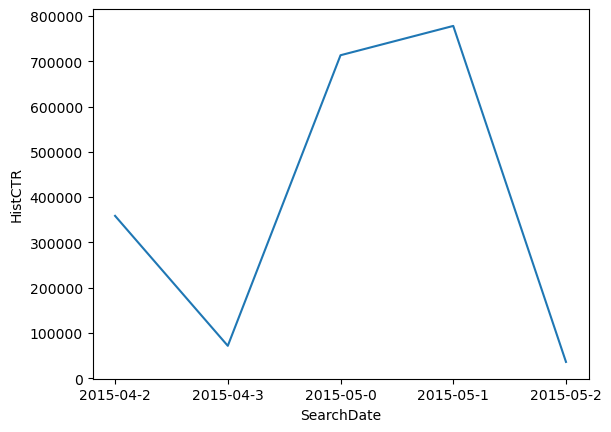

In [23]:
plt.figure()
plt.plot([fig[0][0],fig[1][0],fig[2][0],fig[3][0],fig[4][0]],[fig[0][1],fig[1][1],fig[2][1],fig[3][1],fig[4][1]])
plt.xlabel('SearchDate')
plt.ylabel('HistCTR')
plt.show()

In [ ]:
## in this part, I want to explore the relationship between the SearchDate and PriceAmount

In [25]:
sql = 'select left(SearchDate,9) as date, sum(Price) from df where group by left(SearchDate,9) order by left(SearchDate,9) asc '
spark.sql(sql).show()
fig = spark.sql(sql).collect()

+---------+------------------+
|     date|        sum(Price)|
+---------+------------------+
|2015-04-2| 4.160505639865E11|
|2015-04-3|  1.16405654524E11|
|2015-05-0| 1.334244510843E12|
|2015-05-1|1.4954137633355E12|
|2015-05-2|  5.48694239365E10|
+---------+------------------+



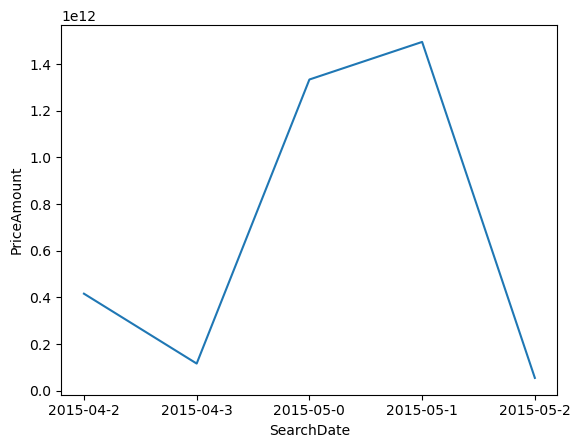

In [26]:
plt.figure()
plt.plot([fig[0][0],fig[1][0],fig[2][0],fig[3][0],fig[4][0]],[fig[0][1],fig[
1][1],fig[2][1],fig[3][1],fig[4][1]])
plt.xlabel('SearchDate')
plt.ylabel('PriceAmount')
plt.show()

In [ ]:
## from these image , we can find out that Price and HistCTR may be related, so we can take regression into account

In [ ]:
## in the following visualization, we explore the relationship between IsClick and other variables
## So, we can prepare for the classification

In [ ]:
## in this part ,I want to use histogram to visualize the data

In [27]:
sql = 'select IsClick from df where IsClick = 1'
click_yes = spark.sql(sql).count()
click_yes

1145882

In [28]:
sql = 'select IsClick from df where IsClick = 0'
click_no = spark.sql(sql).count()
click_no

188972054

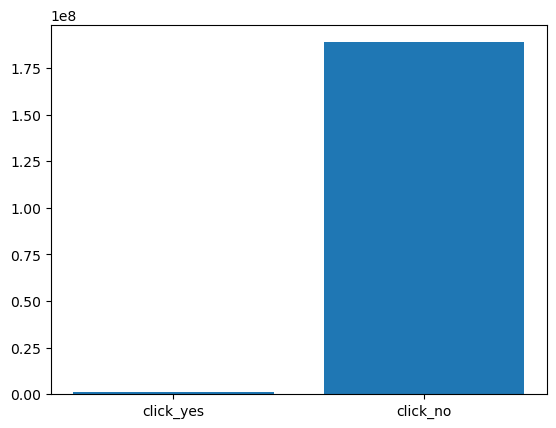

In [29]:
click_name = ['click_yes','click_no']
click_amout = [click_yes , click_no]
plt.bar(click_name , click_amout)
plt.show()

In [30]:
## in this part , we explore the relationship between userdeviceid and IsClick

In [34]:
sql = 'select userdeviceid, count(IsClick) as num from df group by userdeviceid order by userdeviceid '
spark.sql(sql).show()
fig = spark.sql(sql).collect()

+------------+------+
|userdeviceid|   num|
+------------+------+
|           1|    20|
|           2|     2|
|           3|     4|
|           5|113341|
|           6|    26|
|           7|  1038|
|           8|   210|
|           9|   112|
|          10|     6|
|          11|   114|
|          12|     2|
|          13|    10|
|          14|   102|
|          15|  3383|
|          16|     3|
|          18|     2|
|          19|   144|
|          20|  1740|
|          21|    18|
|          23|     8|
+------------+------+
only showing top 20 rows



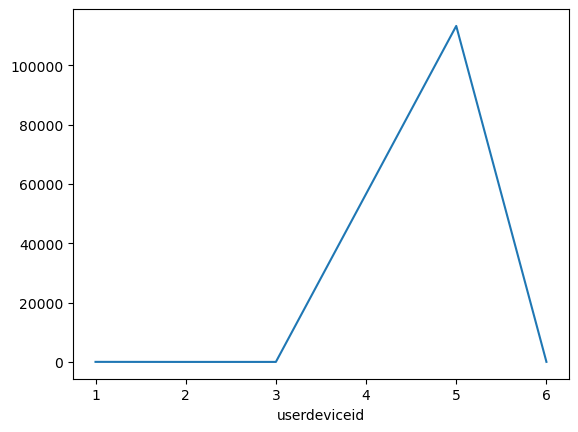

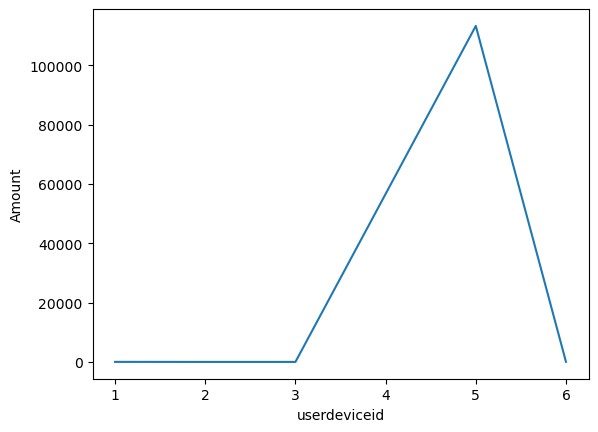

In [36]:
plt.figure()
plt.plot([fig[0][0],fig[1][0],fig[2][0],fig[3][0],fig[4][0]],[fig[0][1],fig[
1][1],fig[2][1],fig[3][1],fig[4][1]])
plt.xlabel('userdeviceid')
plt.ylabel('Amount')
plt.show()

In [ ]:
## in this part , we explore the relationship between CategoryID and IsClick

In [37]:
sql = 'select CategoryID, count(IsClick) as num from df group by CategoryID order by CategoryID '
spark.sql(sql).show()
fig = spark.sql(sql).collect()

+----------+--------+
|CategoryID|     num|
+----------+--------+
|      null|   58586|
|         2| 1923531|
|         3|  377263|
|         4| 5654635|
|         5| 2464734|
|         9| 1589636|
|        11| 2942567|
|        13| 1531639|
|        15|  113086|
|        16|  745100|
|        18| 2200760|
|        22|25209961|
|        25| 1730368|
|        26| 7514681|
|        27| 6534316|
|        29| 2117073|
|        34|35397246|
|        35| 1517416|
|        36|  723772|
|        37| 1107683|
+----------+--------+
only showing top 20 rows



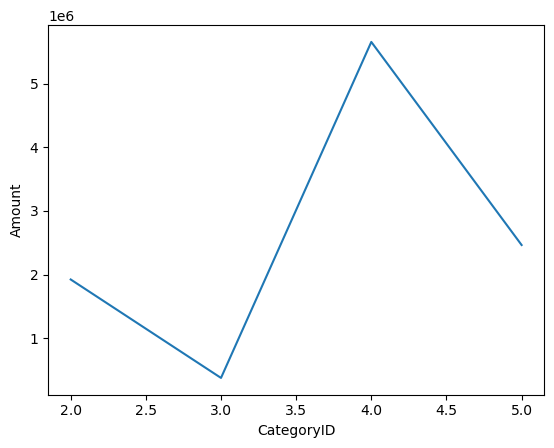

In [38]:
plt.figure()
plt.plot([fig[0][0],fig[1][0],fig[2][0],fig[3][0],fig[4][0]],[fig[0][1],fig[
1][1],fig[2][1],fig[3][1],fig[4][1]])
plt.xlabel('CategoryID')
plt.ylabel('Amount')
plt.show()

In [39]:
data = df.groupby("IsClick").count()
display(data)

DataFrame[IsClick: int, count: bigint]

In [40]:
## split the data into trainDF and testDF
trainDF , testDF = df.randomSplit([0.8,0.2],seed=58)
print(f"""There are {trainDF.count()} rows in the training set,
and {testDF.count()} in the test set""")

There are 152092046 rows in the training set,
and 38025890 in the test set


In [ ]:
## In the first part , we use different regression to predict the HistCTR

In [41]:
## firstly, we only use one feature to get the simple regression and predict the HistCTR
## So, we can compare it with the complex one
from pyspark.ml.feature import VectorAssembler
vecAssembler = VectorAssembler(inputCols=["Price"], outputCol="features",handleInvalid = 'skip')
vecTrainDF = vecAssembler.transform(trainDF)
vecTrainDF.select("Price", "features", "HistCTR").show(10)

+-------+---------+--------+
|  Price| features| HistCTR|
+-------+---------+--------+
|69999.0|[69999.0]|0.001307|
|69999.0|[69999.0]|0.001307|
|69999.0|[69999.0]|0.002183|
|69999.0|[69999.0]|0.002183|
|69999.0|[69999.0]|0.003112|
|69999.0|[69999.0]|0.003112|
|69999.0|[69999.0]|0.003425|
|69999.0|[69999.0]|0.003425|
|69999.0|[69999.0]|0.003431|
|69999.0|[69999.0]|0.003498|
+-------+---------+--------+
only showing top 10 rows



In [43]:
## as we get the intercept and the coefficients,we can know that the the influence of all variables
lr = LinearRegression(featuresCol="features", labelCol="HistCTR")
lrModel = lr.fit(vecTrainDF)
m = lrModel.coefficients[0]
b = round(lrModel.intercept, 6)
print(f"""The formula for the linear regression line is
HistCTR = {m}*Price + {b}""")

The formula for the linear regression line is
HistCTR = -6.975785538507862e-10*Price + 0.010307


In [ ]:
display(lrModel, vecTrainDF)

In [ ]:
## then we can use pipeline in our data process
pipeline = Pipeline(stages=[vecAssembler, lr])
pipelineModel = pipeline.fit(trainDF)
predDF = pipelineModel.transform(testDF)
predDF.select("Price", "features", "HistCTR", "prediction").show(10)

In [ ]:
## in this part we can find out the rmse and r2 of this simple regression and then we can compare it with the more complex one
from pyspark.ml.evaluation import RegressionEvaluator
regressionEvaluator = RegressionEvaluator(
predictionCol="prediction",
labelCol="HistCTR",metricName="rmse")
rmse = regressionEvaluator.evaluate(predDF)
print(f"RMSE is {rmse}")
r2 = regressionEvaluator.setMetricName("r2").evaluate(predDF)
print(f"R2 is {r2}")

In [ ]:
## also we can find out the areaUnderROC of this model
from pyspark.mllib.evaluation import BinaryClassificationMetrics
prediction__labels = predDF.select('prediction','HistCTR').rdd##()
metrics = BinaryClassificationMetrics(prediction__labels)
metrics.areaUnderROC

In [ ]:
display(lrModel, predDF, "ROC")

In [ ]:
from pyspark.ml.feature import VectorAssembler
vecAssembler = VectorAssembler(inputCols=["Price",'CategoryID','IsUserLogged
On','userdeviceid','IsClick','AdID'], outputCol="features",handleInvalid =
'skip')
vecTrainDF = vecAssembler.transform(trainDF)
## as we get the intercept and the coefficients,we can know that the the inf
luence of all variables
lr = LinearRegression(featuresCol="features", labelCol="HistCTR")
lrModel = lr.fit(vecTrainDF)
## in this part , we use CategoryID ,AdID , IsUserLoggedOn ,userdeviceid to
predict HistCTR
rFormula = RFormula(formula="HistCTR ~ CategoryID + AdID + IsUserLoggedOn +
userdeviceid + Price + IsClick",
featuresCol="features",
labelCol="HistCTR",
handleInvalid="skip")
pipeline = Pipeline(stages = [rFormula, lr])
pipelineModel = pipeline.fit(trainDF)
predDF = pipelineModel.transform(testDF)
## And also we can find out the rmse and r2 of this model and compare it with the previous one
from pyspark.ml.evaluation import RegressionEvaluator
regressionEvaluator = RegressionEvaluator(
predictionCol="prediction",
labelCol="HistCTR",
metricName="rmse")
rmse = regressionEvaluator.evaluate(predDF)
r2 = regressionEvaluator.setMetricName("r2").evaluate(predDF)
## in this part we can get the areaUnderROC of this model
## apparently, this model has a better prediction effect
from pyspark.mllib.evaluation import BinaryClassificationMetrics
prediction__labels = predDF.select('prediction','HistCTR').rdd##()
metrics = BinaryClassificationMetrics(prediction__labels)

In [ ]:
a1 = lrModel.coefficients[0]
a2 = lrModel.coefficients[1]
a3 = lrModel.coefficients[2]
a4 = lrModel.coefficients[3]
a5 = lrModel.coefficients[4]
a6 = lrModel.coefficients[5]
#lrModel.coefficients[5]
print(f"RMSE is {rmse}")
print(f"R2 is {r2}")
print(f"""The formula for the linear regression line is
HistCTR = {a1}*Price + {a2}*CategoryID + {a3}*IsUserLoggedOn + {a4}*userdev
iceid + {a5}*IsClick + {a6}*AdID + {a5}""")

In [ ]:
metrics.areaUnderROC

In [ ]:
## as we can see from this formula, the important variables are IsUserLogged On ,IsClick

In [ ]:
## In the second part , we use classification algorithms to predict the variable IsClick
## In this case , we use two different algorithms:LogisticRegression and RandomForestRegressor

In [ ]:
## At first, we should convert the type of IsClick from int to double for the classification
sql = 'select AdID,CategoryID,Price,IsContext,HistCTR,ObjectType,Title,IsUserLoggedOn,userdeviceid , cast(IsClick as double ) from df'
df1 = spark.sql(sql)
df1.printSchema()

In [ ]:
trainDF , testDF = df1.randomSplit([0.8,0.2],seed=58)

In [ ]:
## in this part , we use logisticregression firstly to find out the effect.
vecAssembler = VectorAssembler(inputCols=['AdID','CategoryID','Price','IsCon
text','HistCTR','ObjectType','IsUserLoggedOn','userdeviceid'],
outputCol='features',
handleInvalid = 'skip')
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol = 'IsClick',maxIter=10,regParam=0.01)

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[vecAssembler,lr])
logistic_model = pipeline.fit(trainDF)

In [ ]:
prediction = logistic_model.transform(testDF)
from pyspark.mllib.evaluation import BinaryClassificationMetrics
prediction__labels = prediction.select('prediction','IsClick').rdd##()
metrics = BinaryClassificationMetrics(prediction__labels)

In [ ]:
## in this part , we can get the areaUnderROC
## As we can see , this algorithm is not good enough , so we should find aother algorithm to get a better result
metrics.areaUnderROC

In [ ]:
## In the following part , we use another algorithms to predict the variable
IsClick
## So we can compare the two method to find out the best classification algorithm for our model

In [ ]:
## We use the DecisionTreeRegressor in this part

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor

In [ ]:
dt = DecisionTreeRegressor(labelCol= IsClick )
vecAssembler = VectorAssembler(inputCols=['CategoryID','Price','IsContext',
'HistCTR','ObjectType','IsUserLoggedOn','userdeviceid'],outputCol='features',handleInvalid = 'skip')

dt.setMaxBins(40)
stages = [vecAssembler, dt]
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(trainDF)
dtModel = pipelineModel.stages[-1]
import pandas as pd
featureImp = pd.DataFrame(
list(zip(vecAssembler.getInputCols(), dtModel.featureImportances)),columns=
["feature", "importance"])
featureImp.sort_values(by="importance", ascending=False)